In [1]:
# import the required packages
import numpy as np
from lightcones import linalg as la
from lightcones import models
from lightcones.solvers.schrodinger import solve
import matplotlib.pyplot as plt

In [3]:
# Suppose we are given Hamiltonian in the star form:

# define the Hamiltonian of the spin-boson model

# number of boson chain modes
num_star_modes = 15

# keep in the truncated Fock space only states in which 
# the bosonic chain has no more than max_num_quanta quanta
max_num_quanta = 5

# sparse matrices for the model
m = models.spin_boson(num_star_modes, max_num_quanta)

# Hamitonian for the spin (qubit)
# Rabi (level splitting)
Omega = 2.0
Hs = m.s_p @ m.s_m * Omega / 2

# Hamiltonian for the star
# frequencies of the oscillator
dw = 0.01
w = np.array([1.0 + i*dw for i in range(num_star_modes)])
Hstar = sum([w[i] * m.a_dag[i] @ m.a[i] for i in range(num_star_modes)])

# Coupling to the star modes
c = np.array([i*dw for i in range(num_star_modes)])
# coupling to the star via raising / lowering Pauli matrices of qubit
V = sum([c[i] * m.s_m @ m.a_dag[i] for i in range(num_star_modes)])
V_dag = V.T.conj()

# joint spin-boson Hamiltonian
Hsb_star = Hs + V + V_dag + Hstar

# The qubit is periodically driven
# in order to make quantum dynamics more interesting
def drive(t):
    return(0.1*np.cos(t)) * m.s_x

# The Hamiltonian for the driven spin-boson model
def Hsb_star_driven(t):
    return Hsb_star + drive(t)


In [5]:
# Solve the star model

# The non-stationary Schrodinger equation is solved on a time grid
# [0    dt    2*dt    ...    k*dt  ... ]
# The time grid points are numbered by integer ti
# [0    1     2       ....   k     ... ]
# The time-dependent Hamiltonian is invoked by the solver with ti argument,
# and the corresponding time moment is (ti + 0.5)*dt
# Here 0.5*dt is due to the midpoint integration rule

# Time step
dt = 0.01

# Final grid
t_max = 100
t = np.arange(0, t_max + dt, dt)
n_time = t.size

# Callback function which applies Hamiltonian to the wavefunction at each time grid point ti
def apply_h(ti, psi_in, psi_out):
    H = Hsb_star_driven((ti + 0.5) * dt)
    la.mv(H, psi_in, psi_out, cout=1)

# Here we store the average of observables
s_z_av_1 = []

# Callback function which evaluates observables at each time grid point ti
def eval_o(ti, psi):
    s_z_av_1.append(np.vdot(psi, m.s_z @ psi))
    
# initial condition:
# vacuum state for bosonic chain,
# and ground state for spin (qubit)
psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1.0 
    
# Solve the non-stationary Schrodinger equation
solve(0, n_time-1, dt, apply_h, psi_0, eval_o = eval_o)

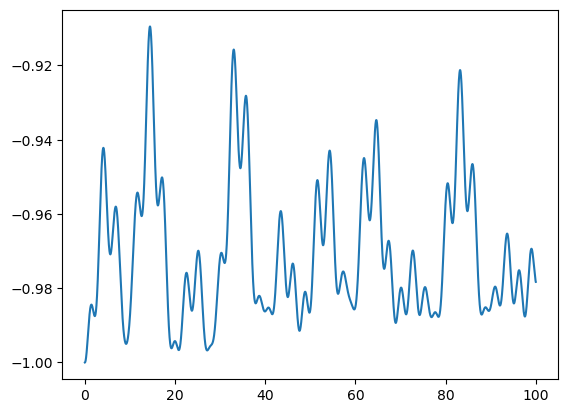

In [7]:
# plot the s_z average fot the star model
s_z_av_1 = np.array(s_z_av_1)
plt.plot(t, s_z_av_1.real)

In [8]:
# Now convert it to the chain model:
# Spectral density from coupling
J = c**2
coupling, e, h = models.to_chain(w, J)

In [9]:
# Now spin-boson model in the chain form

# define the Hamiltonian of the spin-boson model

# Coupling to the chain via raising / lowering Pauli matrices
V = coupling * m.s_m @ m.a_dag[0]
V_dag = V.T.conj()

# Free bosonic chain Hamiltonian (on-site energy e and hopping h)
Hchain = sum([e[i] * m.a_dag[i] @ m.a[i] for i in range(num_star_modes)]) \
    + sum([h[i] * m.a_dag[i + 1] @ m.a[i] + h[i] * m.a_dag[i] @ m.a[i + 1] for i in range(num_star_modes - 1)])
    
# joint Hamiltonian
Hsb_chain = Hs + V + V_dag + Hchain

# The Hamiltonian for the driven spin-boson model
def Hsb_chain_driven(t):
    return Hsb_chain + drive(t)

In [10]:
# Solve the chain model

def apply_h(ti, psi_in, psi_out):
    H = Hsb_chain_driven((ti + 0.5) * dt)
    la.mv(H, psi_in, psi_out, cout=1)

# Here we store the average of observables
s_z_av_2 = []

# Callback function which evaluates observables at each time grid point ti
def eval_o(ti, psi):
    s_z_av_2.append(np.vdot(psi, m.s_z @ psi))
        
# Solve the non-stationary Schrodinger equation
solve(0, n_time-1, dt, apply_h, psi_0, eval_o = eval_o)

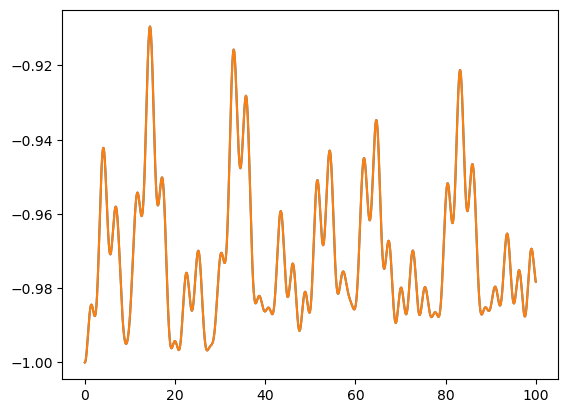

In [11]:
# plot the s_z average fot the star model
s_z_av_2 = np.array(s_z_av_2)
plt.plot(t, s_z_av_1.real)
plt.plot(t, s_z_av_2.real)

In [ ]:
# We see that the star and the chain models are equivanent